In [1]:
import glob
import json

log_dir = "../logs/"

all_logs = []
for log_file in glob.glob(log_dir + "*FE*.json"):
    with open(log_file, "r") as f:
        log_file = log_file.split("results_")[1].split(".")[0]
        all_logs.append([log_file, json.load(f)])

In [2]:
def add_values(acc, entry):
    """
    Add values to an entry dict.
    """
    acc["chamfer"] += entry["chamfer"]
    acc["depth_loss"] += entry ["depth_loss"]
    acc["f_score"] += entry["f_score"]
    acc["iou"] += entry["iou"]
    acc["mask_loss"] += entry["mask_loss"]
    
def average_values(acc, num):
    """
    Average values in an entry dict.
    """
    acc["chamfer"] /= num
    acc["depth_loss"] /= num
    acc["f_score"] /= num
    acc["iou"] /= num
    acc["mask_loss"] /= num


all_avg_vals = {}
for log_file, log_list in all_logs:
    avg_vals = {
        "final": {
            "chamfer": 0,
            "depth_loss": 0,
            "f_score": 0,
            "iou": 0,
            "mask_loss": 0
        },
        "first_stage": {
            "chamfer": 0,
            "depth_loss": 0,
            "f_score": 0,
            "iou": 0,
            "mask_loss": 0
        },
        "initial": {
            "chamfer": 0,
            "depth_loss": 0,
            "f_score": 0,
            "iou": 0,
            "mask_loss": 0
        }
    }
    for _, log in log_list.items():
        add_values(avg_vals["final"], log["final"])
        add_values(avg_vals["first_stage"], log["first_stage"])
        add_values(avg_vals["initial"], log["initial"])

    average_values(avg_vals["final"], len(log_list))
    average_values(avg_vals["first_stage"], len(log_list))
    average_values(avg_vals["initial"], len(log_list))
    
    # Remove the last 2
    log_file = log_file[:-2]
    
    if log_file not in all_avg_vals:
        all_avg_vals[log_file] = avg_vals
    else:
        for key in avg_vals.keys():
            add_values(all_avg_vals[log_file][key], avg_vals[key])
        for key in avg_vals.keys():
            average_values(all_avg_vals[log_file][key], len(log_list))

# Compute global averages
all_avg_vals["global"] = {
    "final": {
        "chamfer": 0,
        "depth_loss": 0,
        "f_score": 0,
        "iou": 0,
        "mask_loss": 0
    },
    "first_stage": {
        "chamfer": 0,
        "depth_loss": 0,
        "f_score": 0,
        "iou": 0,
        "mask_loss": 0
    },
    "initial": {
        "chamfer": 0,
        "depth_loss": 0,
        "f_score": 0,
        "iou": 0,
        "mask_loss": 0
    }
}

for _, avg_vals in all_avg_vals.items():
    for key in avg_vals.keys():
        add_values(all_avg_vals["global"][key], avg_vals[key])
        
for key in all_avg_vals["global"].keys():
    average_values(all_avg_vals["global"][key], len(all_logs))

In [3]:
# Plot final, first_stage, initial for each C
# Use stacked bar chart
import matplotlib.pyplot as plt

def plot_stacked_bar_chart(data, title, field_name=None, yscale=True, key_filters=None, ymin=None, ymax=None):
    if field_name is None:
        field_name = title.lower()
    labels = sorted(list(data.keys()))
    if key_filters is not None:
        labels = [l for l in labels if l in key_filters]
    final = [data[k]["final"][field_name] for k in labels]
    first_stage = [data[k]["first_stage"][field_name] for k in labels]
    initial = [data[k]["initial"][field_name] for k in labels]

    x = range(len(labels))
    
    if "iou" in field_name:
        # Compute 1 - x
        final = [1 - x for x in final]
        first_stage = [1 - x for x in first_stage]
        initial = [1 - x for x in initial]
    plt.bar(x, initial, color='darkorange')
    plt.bar(x, first_stage, color='cornflowerblue')
    plt.bar(x, final, color='darkorchid')
    plt.xticks(x, [l.replace("_", " ").split(' ')[1] if l != "global" else "Global" for l in labels])
    # Change xticks angle
    plt.xticks(rotation=90)
    if yscale:
        plt.yscale("log")
    elif ymin is not None and ymax is not None:
        plt.ylim(ymin, ymax)
    # Add legend
    plt.legend(["Initial", "First Stage", "Final Stage"])
    plt.title(title)
    plt.show()


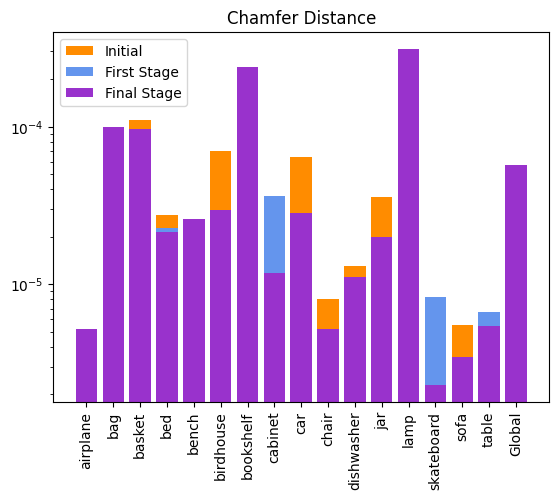

In [4]:
plot_stacked_bar_chart(all_avg_vals, " Chamfer Distance", "chamfer", yscale=True)

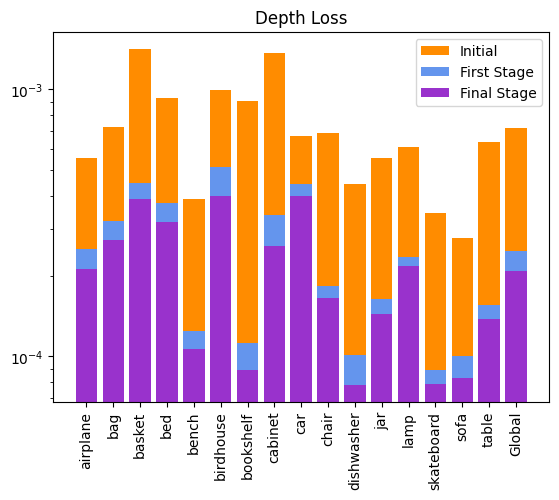

In [5]:
plot_stacked_bar_chart(all_avg_vals, "Depth Loss", "depth_loss")

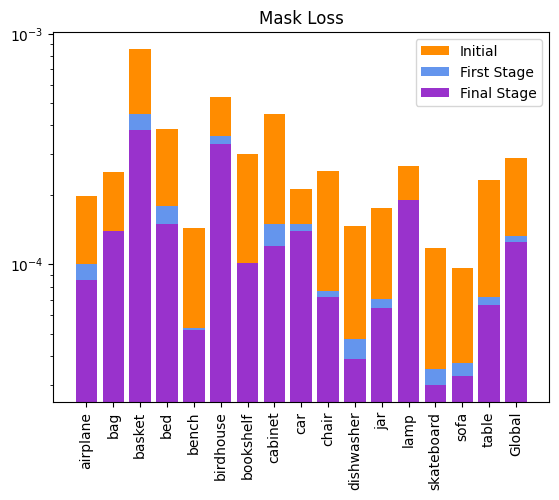

In [6]:
plot_stacked_bar_chart(all_avg_vals, "Mask Loss", "mask_loss")

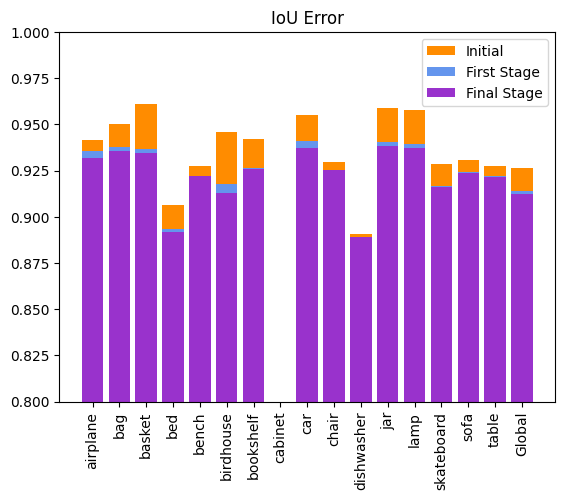

In [7]:
plot_stacked_bar_chart(all_avg_vals, "IoU Error", "iou", yscale=False, ymin=0.8, ymax=1)

In [8]:
from copy import deepcopy

# make a table with all metrics and all configurations
def print_table(data, key_filters=None):
    # Deep clone data dict
    data = deepcopy(data)
    labels = sorted(list(data.keys()))
    if key_filters is not None:
        labels = [l for l in labels if l in key_filters]
    matrix = []
    print("Configuration\tChamfer (Initial)\tChamfer (First Stage)\tChamfer (Final Stage)\tDepth Loss (Initial)\tDepth Loss (First Stage)\tDepth Loss (Final Stage)\tIoU (Initial)\tIoU (First Stage)\tIoU (Final Stage)\tMask Loss (Initial)\tMask Loss (First Stage)\tMask Loss (Final Stage)")
    for label in labels:
        final = data[label]["final"]
        first_stage = data[label]["first_stage"]
        initial = data[label]["initial"]
        # Scale all chamfer values by 10**4
        initial["chamfer"] *= 10**4
        first_stage["chamfer"] *= 10**4
        final["chamfer"] *= 10**4
        # Scale all depth loss values by 10**2
        initial["depth_loss"] *= 10**2
        first_stage["depth_loss"] *= 10**2
        final["depth_loss"] *= 10**2
        # Scale all mask loss values by 10**2
        initial["mask_loss"] *= 10**2
        first_stage["mask_loss"] *= 10**2
        final["mask_loss"] *= 10**2
        print(f"{label}\t{initial['chamfer']:.4f}\t{first_stage['chamfer']:.4f}\t{final['chamfer']:.4f}\t{initial['depth_loss']:.4f}\t{first_stage['depth_loss']:.4f}\t{final['depth_loss']:.4f}\t{initial['iou']:.4f}\t{first_stage['iou']:.4f}\t{final['iou']:.4f}\t{initial['mask_loss']:.4f}\t{first_stage['mask_loss']:.4f}\t{final['mask_loss']:.4f}")

        matrix += [[final["chamfer"], final["depth_loss"], 1 - final["iou"], final["mask_loss"]]]
    return matrix
mat = print_table(all_avg_vals)

Configuration	Chamfer (Initial)	Chamfer (First Stage)	Chamfer (Final Stage)	Depth Loss (Initial)	Depth Loss (First Stage)	Depth Loss (Final Stage)	IoU (Initial)	IoU (First Stage)	IoU (Final Stage)	Mask Loss (Initial)	Mask Loss (First Stage)	Mask Loss (Final Stage)
FE_airplane	0.0350	0.0488	0.0522	0.0553	0.0253	0.0212	0.0583	0.0643	0.0682	0.0197	0.0101	0.0085
FE_bag	0.1039	0.0998	0.9888	0.0724	0.0322	0.0273	0.0496	0.0623	0.0642	0.0251	0.0130	0.0139
FE_basket	1.1011	0.8181	0.9647	0.1419	0.0445	0.0389	0.0387	0.0633	0.0657	0.0861	0.0448	0.0384
FE_bed	0.2763	0.2283	0.2155	0.0931	0.0377	0.0317	0.0935	0.1064	0.1084	0.0387	0.0178	0.0150
FE_bench	0.0470	0.0886	0.2603	0.0387	0.0125	0.0106	0.0723	0.0777	0.0782	0.0144	0.0053	0.0052
FE_birdhouse	0.7055	0.2421	0.2957	0.0990	0.0510	0.0400	0.0542	0.0821	0.0872	0.0531	0.0359	0.0333
FE_bookshelf	0.1049	0.2362	2.4049	0.0902	0.0113	0.0089	0.0581	0.0735	0.0740	0.0299	0.0070	0.0101
FE_cabinet	0.2392	0.3646	0.1171	0.1370	0.0338	0.0259	0.2333	0.2468	0.2476	0.

In [9]:
import numpy as np

mat = np.array(mat)
# Replace each value by its rank
mat = np.argsort(np.argsort(mat, axis=0), axis=0)

In [10]:
# Compute row-wise average
row_avg = np.mean(mat, axis=1)

In [11]:
print("\n".join([str(k) for k in row_avg]))

7.5
12.75
13.75
9.0
5.75
11.25
9.0
6.5
13.0
6.0
2.0
8.25
13.5
1.5
3.0
5.0
8.25


In [12]:
mat

array([[ 3,  9, 11,  7],
       [14, 12, 13, 12],
       [13, 14, 12, 16],
       [ 8, 13,  2, 13],
       [ 9,  4,  7,  3],
       [11, 15,  4, 15],
       [15,  3, 10,  8],
       [ 6, 11,  0,  9],
       [10, 16, 15, 11],
       [ 2,  7,  9,  6],
       [ 5,  0,  1,  2],
       [ 7,  6, 16,  4],
       [16, 10, 14, 14],
       [ 0,  1,  5,  0],
       [ 1,  2,  8,  1],
       [ 4,  5,  6,  5],
       [12,  8,  3, 10]])